# Generate PDF/A files from docTR output

These files have also a readable text layer on top of the image, which can be used to search in a document with any PDF-Viewer.

In [1]:
# Install the most up-to-date version from GitHub

# TensorFlow
# !pip install python-doctr[tf,viz]@git+https://github.com/mindee/doctr.git

# PyTorch
# First we have to uninstall the preinstalled tensorflow version if we want to work with PyTorch as backend
# because the env variables USE_TORCH=1 / USE_TF=1 doesn't have an effect in Colab
!pip uninstall -y tensorflow
!pip install python-doctr[torch,viz]@git+https://github.com/mindee/doctr.git

# Install additional requirements (for hOCR conversion and PDF file merging)
!pip install ocrmypdf
!pip install PyPDF2

Found existing installation: tensorflow 2.18.0
Uninstalling tensorflow-2.18.0:
  Successfully uninstalled tensorflow-2.18.0
  Cloning https://github.com/mindee/doctr.git to /tmp/pip-install-zt661ixl/python-doctr_c3425b3031bb48b6a98352cc4dd5894a
  Running command git clone --filter=blob:none --quiet https://github.com/mindee/doctr.git /tmp/pip-install-zt661ixl/python-doctr_c3425b3031bb48b6a98352cc4dd5894a
  Resolved https://github.com/mindee/doctr.git to commit 59595e80a2c6634b92c81c707871306a64b025f1
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.2/48.2 kB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 18.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 21.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 98.5 MB/s eta 0:00:

We will use `ocrmypdf` to parse our exported XML-Tree/File in hOCR format ([hOCR convention](https://github.com/kba/hocr-spec/blob/master/1.2/spec.md)) and `PyPDF` to merge the single generated PDF/A files into one.

In [2]:
# Imports
import os
import base64
import re
from tempfile import TemporaryDirectory

from PyPDF2 import PdfMerger, PdfReader
from doctr.io import DocumentFile
from doctr.models import ocr_predictor, from_hub
from PIL import Image
from ocrmypdf.hocrtransform import HocrTransform

## OCR the files and show the results

Now we are ready to start the OCR process and show the results.

In [ ]:
# Download a sample
!wget https://github.com/mindee/doctr/releases/download/v0.1.0/Versicherungsbedingungen-08-2021.pdf

In [ ]:
# Read the file
docs = DocumentFile.from_pdf("1tbl.pdf")
# The document contains german text let's use a multilingual fine tuned model from the Hugging Face hub.
reco_model = from_hub("Felix92/doctr-torch-parseq-multilingual-v1")
model = ocr_predictor(det_arch='fast_base', reco_arch=reco_model, pretrained=True)
# we will grab only the first two pages from the pdf for demonstration
result = model(docs[:2])
result.show()

  0%|          | 0/16991778 [00:00<?, ?it/s]

  0%|          | 0/18240683 [00:00<?, ?it/s]

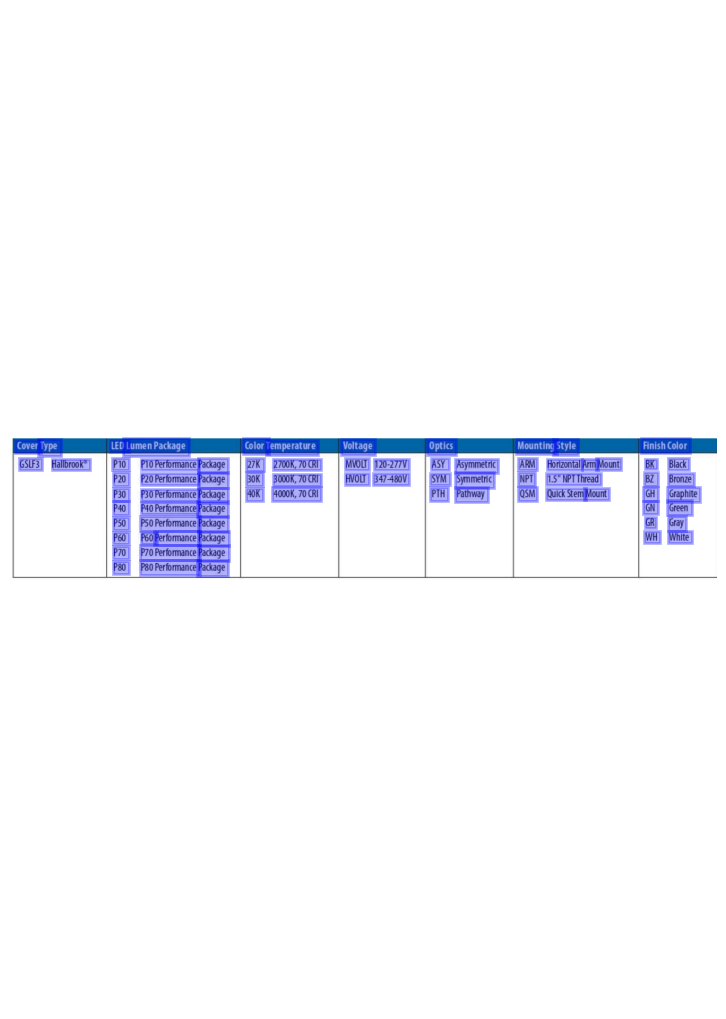

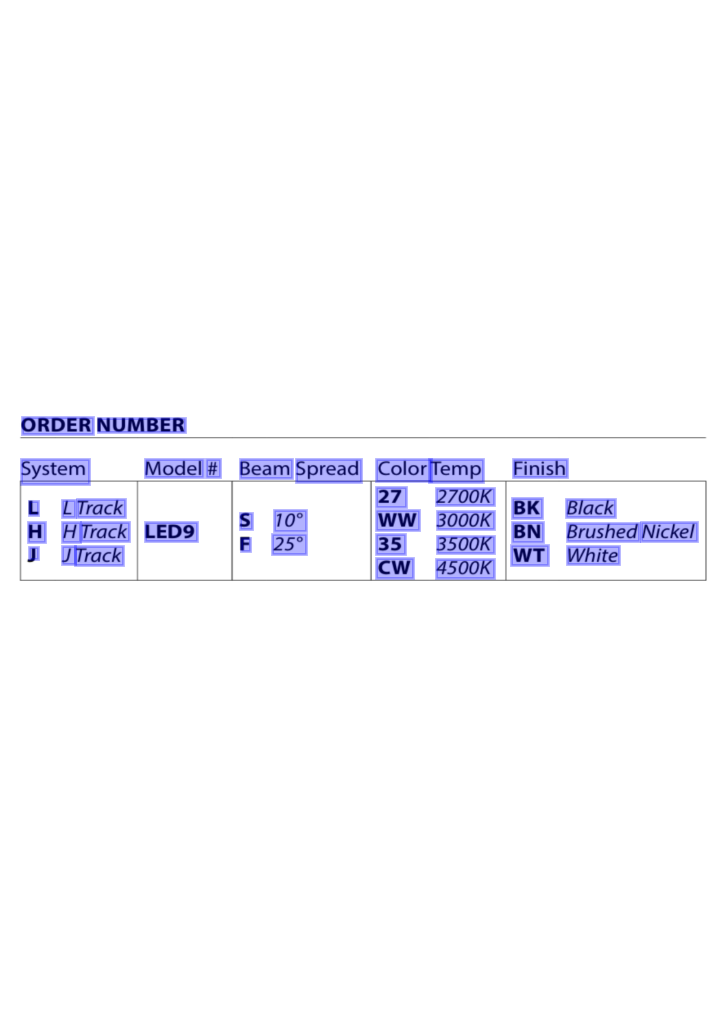

In [39]:
from doctr.models import ocr_predictor
model = ocr_predictor('db_mobilenet_v3_large','crnn_mobilenet_v3_large', pretrained=True, assume_straight_pages=True, preserve_aspect_ratio=True)
result = model(docs[:2])
result.show()

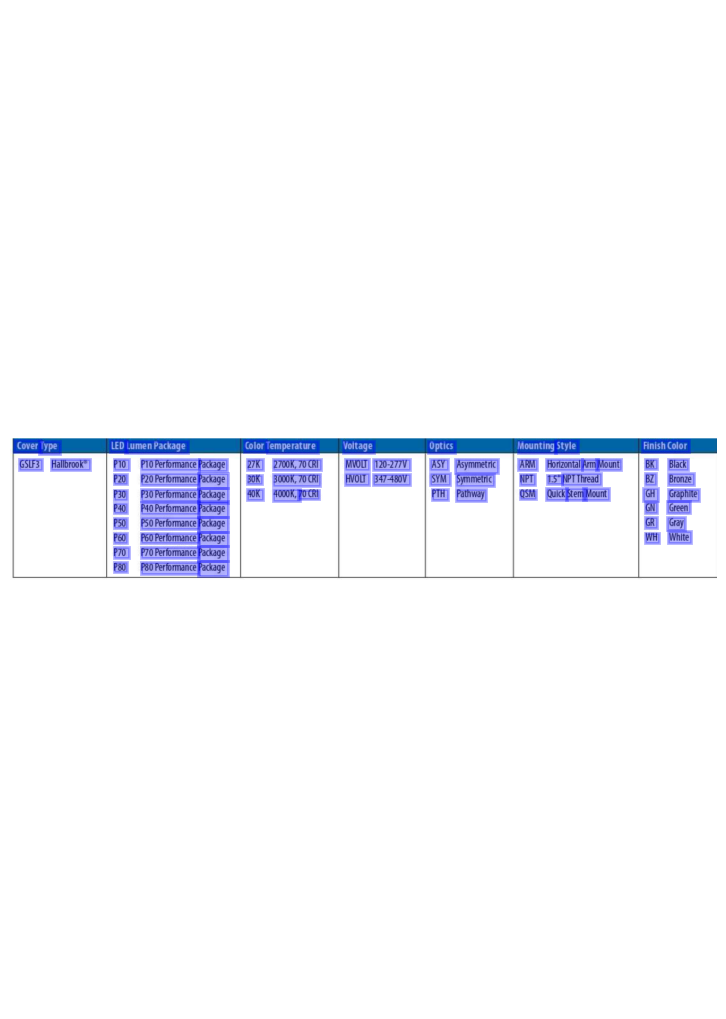

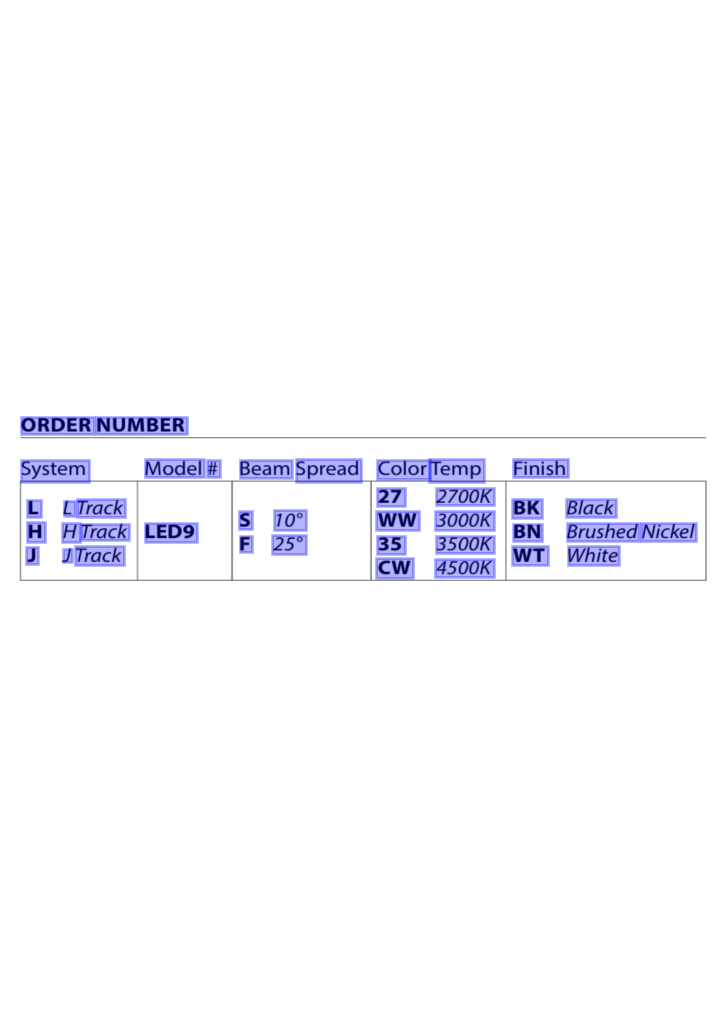

In [34]:
from doctr.models import ocr_predictor
model = ocr_predictor('linknet_resnet18', pretrained=True, assume_straight_pages=True, preserve_aspect_ratio=True)
result = model(docs[:2])
result.show()

  0%|          | 0/102021912 [00:00<?, ?it/s]

  0%|          | 0/63286381 [00:00<?, ?it/s]

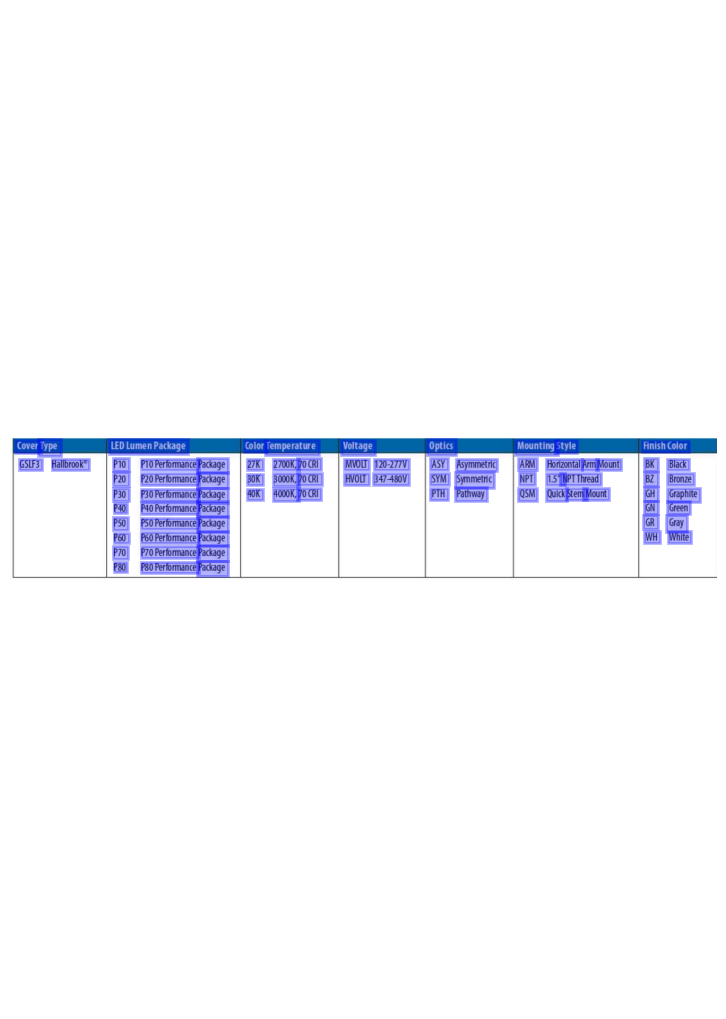

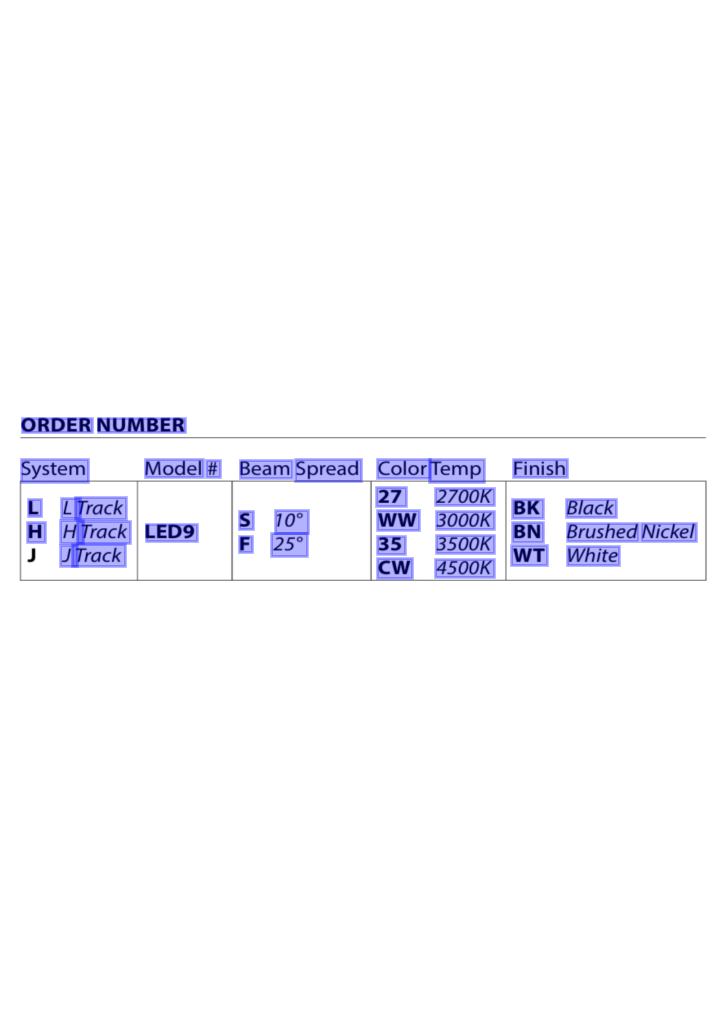

In [23]:
# Read the file
docs = DocumentFile.from_pdf("1tbl.pdf")
# The document contains german text let's use a multilingual fine tuned model from the Hugging Face hub.
# reco_model = from_hub("Felix92/doctr-torch-parseq-multilingual-v1")
# model = ocr_predictor(det_arch='fast_base', reco_arch=reco_model, pretrained=True)
# we will grab only the first two pages from the pdf for demonstration
model = ocr_predictor('db_resnet50', 'crnn_vgg16_bn', pretrained=True)
# input_page = (255 * np.random.rand(800, 600, 3)).astype(np.uint8)
out = model(docs[:2])
# result = model(docs[:2])
out.show()

In [40]:
dicdt = result.pages[1].export()

In [41]:
for i in range(len(dicdt['blocks'])):
  for j in range(len(dicdt['blocks'][i]['lines'])):
    for k in range(len(dicdt['blocks'][i]['lines'][j]['words'])):
      dicdt['blocks'][i]['lines'][j]['words'][k]['value']
      print(dicdt['blocks'][i]['lines'][j]['words'][k]['value'])
    print('-----------')
  print('\\\\\\\\')


ORDER
NUMBER
-----------
System
-----------
Model
#
Beam
Spread
Color
Temp
-----------
Finish
-----------
27
-----------
2700K
-----------
L
L
Track
-----------
BK
Black
-----------
S
10°
-----------
WW
3000K
-----------
H
H
Track
LED9
-----------
BN
Brushed
Nickel
-----------
I
J
Track
-----------
F
25°
-----------
35
-----------
3500K
WT
White
-----------
CW
4500K
-----------
\\\\


## Export as PDF/A
In this section we will export our documents as PDF/A files.

We show 3 possible options for this.

### All as single PDF/A file
All files will be saved as single file.

In [4]:
# returns: list of tuple where the first element is the (bytes) xml string and the second is the ElementTree
xml_outputs = result.export_as_xml()

# iterate through the xml outputs and images and export to pdf/a
# the image is optional else you can set invisible_text=False and the text will be printed on a blank page
with TemporaryDirectory() as tmpdir:
    for i, (xml, img) in enumerate(zip(xml_outputs, docs)):
        # write the images temp
        Image.fromarray(img).save(os.path.join(tmpdir, f"{i}.jpg"))
        # write the xml content temp
        with open(os.path.join(tmpdir, f"{i}.xml"),"w") as f :
            f.write(xml_outputs[i][0].decode())
        # Init hOCR transfomer
        hocr = HocrTransform(hocr_filename=os.path.join(tmpdir, f"{i}.xml"), dpi=300)
        # Save as PDF/A
        hocr.to_pdf(out_filename=f"{i}.pdf", image_filename=os.path.join(tmpdir, f"{i}.jpg"))

### All merged into one PDF/A file
All PDF/A files will be merged into one PDF/A file.

In [5]:
# returns: list of tuple where the first element is the (bytes) xml string and the second is the ElementTree
xml_outputs = result.export_as_xml()

# you can also merge multiple pdfs into one

merger = PdfMerger()

with TemporaryDirectory() as tmpdir:
    for i, (xml, img) in enumerate(zip(xml_outputs, docs)):
        # write the images temp
        Image.fromarray(img).save(os.path.join(tmpdir, f"{i}.jpg"))
        # write the xml content temp
        with open(os.path.join(tmpdir, f"{i}.xml"),"w") as f :
            f.write(xml_outputs[i][0].decode())
        # Init hOCR transfomer
        hocr = HocrTransform(hocr_filename=os.path.join(tmpdir, f"{i}.xml"), dpi=300)
        # Save as PDF/A
        hocr.to_pdf(out_filename=os.path.join(tmpdir, f"{i}.pdf"), image_filename=os.path.join(tmpdir, f"{i}.jpg"))
        # Append to merger
        merger.append(f'{tmpdir}/{i}.pdf')
    # Save as combined pdf
    merger.write(f'docTR-PDF.pdf')

### All as base64 encoded PDF/A files
All PDF/A files will be saved as base64 strings in a list.

In [6]:
# returns: list of tuple where the first element is the (bytes) xml string and the second is the ElementTree
xml_outputs = result.export_as_xml()

# or encode the pdfs into base64 (Rest API usage)
base64_encoded_pdfs = list()

with TemporaryDirectory() as tmpdir:
    for i, (xml, img) in enumerate(zip(xml_outputs, docs)):
        # write the images temp
        Image.fromarray(img).save(os.path.join(tmpdir, f"{i}.jpg"))
        # write the xml content temp
        with open(os.path.join(tmpdir, f"{i}.xml"),"w") as f :
            f.write(xml_outputs[i][0].decode())
        # Init hOCR transfomer
        hocr = HocrTransform(hocr_filename=os.path.join(tmpdir, f"{i}.xml"), dpi=300)
        # Save as PDF/A
        hocr.to_pdf(out_filename=os.path.join(tmpdir, f"{i}.pdf"), image_filename=os.path.join(tmpdir, f"{i}.jpg"))
        with open(os.path.join(tmpdir, f"{i}.pdf"), "rb") as f:
            base64_encoded_pdfs.append(base64.b64encode(f.read()))

print(f'{len(base64_encoded_pdfs)} pdfs encoded')

2 pdfs encoded


## How can I use a PDF/A?
You can open the saved pdf's with any PDF-Viewer and type some words you are searching for in the document.

Matches will be highlighted in the text layer.

Or you use Python to search, for example words in the text layer.

In [7]:
# search specific words in the pdf and print all matches
pattern = "Allianz"
file_name = "docTR-PDF.pdf"

reader = PdfReader(file_name)
num_pages = len(reader.pages)

for i in range(0, num_pages):
    page = reader.pages[i]
    text = page.extract_text()

    for match in re.finditer(pattern, text):
        print(f'Page no: {i} | Match: {match}')

## To go further
[Wikipedia PDF/A](https://en.wikipedia.org/wiki/PDF/A)

[Difference between PDF/A and PDF](https://askanydifference.com/difference-between-pdf-a-and-pdf/)

### Happy Coding :)